In [170]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.metrics import mean_squared_error

In [171]:
# configure plots
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 6,4

# Data

## Raw Data

In [172]:
X = pd.read_csv('./9_Station/X.csv', index_col=0)
y = pd.read_csv('./9_Station/y.csv', index_col=0)

In [173]:
y.head()

,pt,q,q/pt,eta_median,phi_median,theta_median,hit_count
0,30.163197,1.0,0.033153,1.620299,141.058455,22.381725,6.0
1,45.874340,1.0,0.021799,2.020179,-141.673995,15.110317,8.0
2,89.106621,-1.0,-0.011223,1.684747,-110.063550,21.016869,7.0
3,58.869408,1.0,0.016987,2.388656,113.099700,10.484757,8.0
4,57.881783,1.0,0.017277,2.125661,47.813921,13.612605,8.0


In [174]:
scaler = MinMaxScaler(feature_range=(-1, 1))
y_standard = scaler.fit_transform(pd.DataFrame(y['pt']))
y_standard = pd.DataFrame(y_standard, columns=['pt_s'], index=y.index)
y['pt_s'] = y_standard['pt_s']

In [175]:
X = X.fillna(0)
# X = normalize(X)

## Train Test Split

In [176]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

# Baseline Model

In [146]:
from sklearn.ensemble import RandomForestRegressor
regressor_RF = RandomForestRegressor(n_estimators = 80, max_depth = 10)

## Predict pt

In [147]:
regressor_RF.fit(X_train, y_train['pt'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [148]:
y_pred = regressor_RF.predict(X_test)

# Visualize Baseline Model

In [185]:
visual = y_test.reset_index()

## Predict pt

In [203]:
visual['pt_pred'] = scaler.inverse_transform(pd.DataFrame(y_pred))

In [204]:
visual['q/pt_pred'] = visual['q'] / visual['pt_pred']

In [205]:
visual['delta_1/pt'] = 1/visual['pt'] - 1/visual['pt_pred']

In [206]:
visual['relative_delta'] = (visual['pt_pred'] - visual['pt']) / visual['pt']

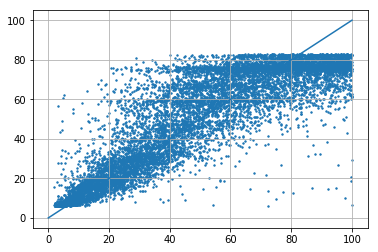

In [207]:
visual_sample = visual.sample(n = 10000)
fig, ax = plt.subplots()
line = [0, 100]
ax.plot(line, line)
ax.scatter(visual_sample['pt'], 
           visual_sample['pt_pred'], 
#            c = visual_sample['hit_count'], 
           cmap = 'copper', 
           s = 2, 
           alpha = 1
          )
# plt.ylim(-1, 1)
ax.grid(True)

## Bias and Resolution

In [208]:
points = range(2, 100)
bias = []
resolution = []

In [209]:
for i in points:
    temp = visual[(visual['pt']>i) & (visual['pt']<i+1)]
    bias.append(temp['delta_1/pt'].mean())
    resolution.append(temp['delta_1/pt'].std())
#     resolution.append((temp['delta_1/pt'].max() - temp['delta_1/pt'].min())/2)

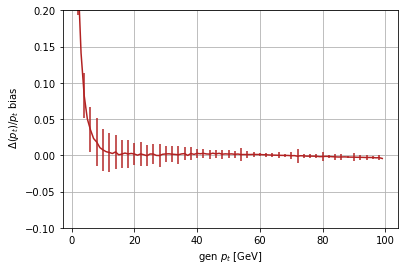

In [212]:
fig, ax = plt.subplots()
ax.errorbar(points, bias, color='firebrick', yerr=resolution, errorevery=2)
plt.ylim(-0.1, 0.2)
ax.set(xlabel=r'gen $p_t$ [GeV]', ylabel=r' $\Delta(p_t)/p_t$ bias')
ax.grid(True)
# ax.set_title('all errorbars')
fig.savefig('9s_nn.jpg', format='jpg', dpi=900)

# NN

In [198]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor

In [199]:
X.shape

(138011, 37)

In [200]:
# 搭建模型
def create_model():
    classifier = Sequential()
    # 输入层及第一个隐藏层
    classifier.add(Dense(activation="tanh", 
                         input_dim= 37,
                         units=80, 
                         kernel_initializer="RandomUniform"
#                          kernel_regularizer=regularizers.l2(0.1),
#                          activity_regularizer=regularizers.l1(0.1)
                        ))
    # 第二个隐藏层
    classifier.add(Dense(activation="tanh", 
                         units=50, 
                         kernel_initializer="RandomUniform"
#                          kernel_regularizer=regularizers.l2(0.1),
#                          activity_regularizer=regularizers.l1(0.1)
                        ))
    # 第三个隐藏层
    classifier.add(Dense(activation="tanh", 
                         units=30, 
                         kernel_initializer="RandomUniform"
#                          kernel_regularizer=regularizers.l2(0.1),
#                          activity_regularizer=regularizers.l1(0.1)
                        ))
    # 输出层
    classifier.add(Dense(activation="tanh", 
                         units=1, 
                         kernel_initializer="RandomUniform"))
    
    classifier.compile(optimizer = 'adam', 
                       loss = 'mse', 
                       metrics = ['mse'])
    return classifier

model = KerasRegressor(build_fn=create_model)

In [201]:
model.fit(X_train,
          y_train['pt_s'], 
          validation_data = (X_test, y_test['pt_s']),
          batch_size=5, 
          epochs = 20)

Train on 110408 samples, validate on 27603 samples
Epoch 1/20
110408/110408 [==============================] - 50s 454us/step - loss: 0.1665 - mean_squared_error: 0.1665 - val_loss: 0.1208 - val_mean_squared_error: 0.1208
Epoch 2/20
110408/110408 [==============================] - 46s 420us/step - loss: 0.1154 - mean_squared_error: 0.1154 - val_loss: 0.1044 - val_mean_squared_error: 0.1044
Epoch 3/20
110408/110408 [==============================] - 46s 418us/step - loss: 0.1066 - mean_squared_error: 0.1066 - val_loss: 0.0980 - val_mean_squared_error: 0.0980
Epoch 4/20
110408/110408 [==============================] - 46s 418us/step - loss: 0.1027 - mean_squared_error: 0.1027 - val_loss: 0.0932 - val_mean_squared_error: 0.0932
Epoch 5/20
110408/110408 [==============================] - 44s 400us/step - loss: 0.0993 - mean_squared_error: 0.0993 - val_loss: 0.0978 - val_mean_squared_error: 0.0978
Epoch 6/20
110408/110408 [==============================] - 43s 387us/step - loss: 0.0967 - me

In [202]:
y_pred = model.predict(X_test)

In [211]:
visual.to_csv('result_9_full_nn_run2.csv')

Run1: 60-45-30

Run2: 80-50-30